In [3]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

In [4]:
from databroker.assets.handlers_base import HandlerBase
from collections import namedtuple


class PizzaBoxEncHandlerTxt(HandlerBase):
    encoder_row = namedtuple('encoder_row',
                             ['ts_s', 'ts_ns', 'encoder', 'index', 'state'])
    "Read PizzaBox text files using info from filestore."
    def __init__(self, fpath, chunk_size):
        self._fpath = fpath
        self.chunk_size = chunk_size
        with open(fpath, 'r') as f:
            self.lines = list(f)

    def __call__(self, chunk_num):
        cs = self.chunk_size
        return [self.encoder_row(*(int(v) for v in ln.split()))
                for ln in self.lines[chunk_num*cs:(chunk_num+1)*cs]]

    def get_file_list(self, chunk_num):
        return [self._fpath]


class PizzaBoxDIHandlerTxt(HandlerBase):
    di_row = namedtuple('di_row', ['ts_s', 'ts_ns', 'encoder', 'index', 'di'])
    "Read PizzaBox text files using info from filestore."
    def __init__(self, fpath, chunk_size):
        self._fpath = fpath
        self.chunk_size = chunk_size
        with open(fpath, 'r') as f:
            self.lines = list(f)

    def __call__(self, chunk_num):
        cs = self.chunk_size
        return [self.di_row(*(int(v) for v in ln.split()))
                for ln in self.lines[chunk_num*cs:(chunk_num+1)*cs]]

    def get_file_list(self, chunk_num):
        return [self._fpath]

class PizzaBoxAnHandlerTxt(HandlerBase):
    encoder_row = namedtuple('encoder_row', ['ts_s', 'ts_ns', 'index', 'adc'])
    "Read PizzaBox text files using info from filestore."

    bases = (10, 10, 10, 16)
    def __init__(self, fpath, chunk_size):
        self._fpath = fpath
        self.chunk_size = chunk_size
        with open(fpath, 'r') as f:
            self.lines = list(f)

    def __call__(self, chunk_num):

        cs = self.chunk_size
        return [self.encoder_row(*(int(v, base=b) for v, b in zip(ln.split(), self.bases)))
                for ln in self.lines[chunk_num*cs:(chunk_num+1)*cs]]

    def get_file_list(self, chunk_num):
        return [self._fpath]


In [15]:
import os
from databroker import Broker

db = Broker.named("qas")

db.reg.register_handler('PIZZABOX_AN_FILE_TXT',
                        PizzaBoxAnHandlerTxt, overwrite=True)
db.reg.register_handler('PIZZABOX_ENC_FILE_TXT',
                        PizzaBoxEncHandlerTxt, overwrite=True)
db.reg.register_handler('PIZZABOX_DI_FILE_TXT',
                        PizzaBoxDIHandlerTxt, overwrite=True)



def get_dataset(uid, dataset_name):
    hdr = db[uid]
    events = list(hdr.events(dataset_name))
    datum = events[0]['data'][dataset_name]
    resource = db.reg.resource_given_datum_id(datum)

    resource_id = resource['uid']

    # handler instance
    handler = db.reg.get_spec_handler(resource_id)

    # get the datum_kwargs, need a wrapper
    datums = list(db.reg.datum_gen_given_resource(resource_id))
    datum_kwargs = [datum['datum_kwargs'] for datum in datums]

    file_list = handler.get_file_list(datum_kwargs)

    print("loading from file {}".format(file_list[0]))
    gg=np.loadtxt(file_list[0])

    return gg

uid = '09645d0a-cdb1-444e-96d1-3ec7e9f0795b'
hdr = db[uid]
dataset_name = 'pb1_enc1'


gg = get_dataset(uid, dataset_name)

loading from file /nsls2/xf07bm/data/pb_data/en_d773f0


<IPython.core.display.Javascript object>


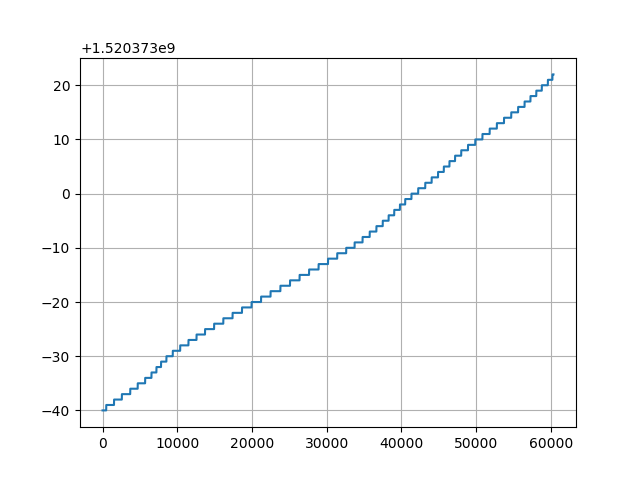

<IPython.core.display.Javascript object>


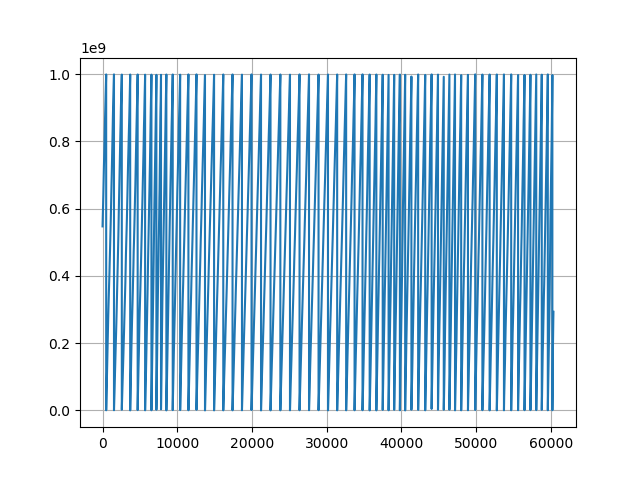

In [16]:
plt.figure()
plt.plot(gg[:,0])
plt.grid()
plt.figure()
plt.plot(gg[:,1])
plt.grid()

<IPython.core.display.Javascript object>


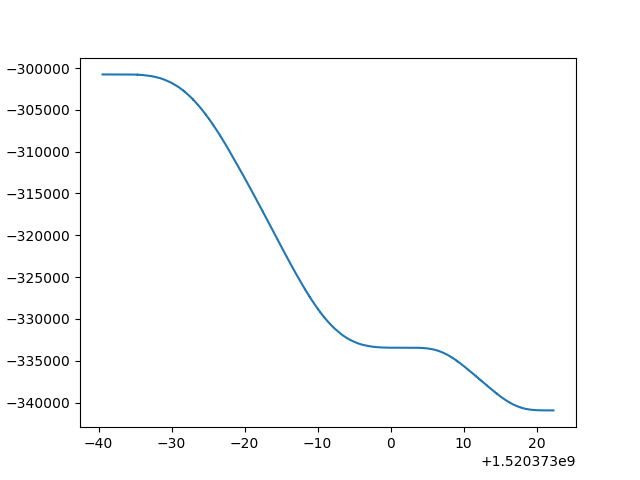

In [17]:
plt.figure()
time=(gg[:,0]+gg[:,1]*1e-9)


plt.plot((gg[:,0]+gg[:,1]*1e-9),gg[:,2])